In [253]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv


from sshtunnel import SSHTunnelForwarder
import pymysql

import matplotlib.pyplot as plt

from datetime import datetime
import holidays

current_date = datetime.now().strftime('%Y-%m-%d')

# kr_holidays = holidays.SouthKorea(years=2025)

# 공휴일 획인
# print(kr_holidays.get("2025-08-15"))  

load_dotenv()

SSH_HOST = os.getenv("SSH_HOST")
SSH_PORT = int(os.getenv("SSH_PORT", 22))
SSH_USER = os.getenv("SSH_USER")
SSH_KEY_PATH = os.getenv("SSH_KEY_PATH")

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT", 3306))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_ORDER_SERVICE = os.getenv("DB_ORDER_SERVICE")

def query_db(query, params=None):
    # SSH 키 로드
    ssh_key = SSH_KEY_PATH
    
    with SSHTunnelForwarder(
        (SSH_HOST, SSH_PORT),
        ssh_username=SSH_USER,
        ssh_pkey=ssh_key,  # 로드된 키 객체 또는 파일 경로
        remote_bind_address=(DB_HOST, DB_PORT)
    ) as tunnel:
        with pymysql.connect(
            host='127.0.0.1',
            port=tunnel.local_bind_port,
            user=DB_USER,
            password=DB_PASSWORD,
            database=DB_ORDER_SERVICE,
            charset='utf8mb4'
        ) as conn:    
            try:
                df = pd.read_sql(query, conn, params=params)
                if df.empty and len(df.columns) > 0:
                    with conn.cursor() as cursor:
                        cursor.execute(query, params)
                        rows = cursor.fetchall()
                        if rows:
                            df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])
            except Exception as e:
                print(f"[ERROR] 데이터 조회 중 오류: {e}")  # f-string 수정
                raise
    return df                     


plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False 

In [254]:
def get_total_quantity(start_date, end_date) :
    params = {
        'start_date': start_date,
        'end_date' : end_date
    }
    
    query = """
        CALL order_service.get_total_quantity_list(%(start_date)s, %(end_date)s)
    """

    return query_db(query, params)

df = get_total_quantity('2025-06-30', current_date)

df.head()

,product_name,delivery_date,total_quantity,total_amount
0,가정식 도시락,2025-06-30,1513.0,12826200.0
1,가정식 도시락 곱빼기,2025-06-30,39.0,370500.0
2,가정식 도시락(석식),2025-06-30,9.0,63000.0
3,케이터링,2025-06-30,51.0,561000.0
4,프레시박스 - 샐러드밀,2025-06-30,224.0,1887300.0


In [255]:
df['date'] = pd.to_datetime(df['delivery_date'])
df['day'] = df['date'].dt.day_name()

years = pd.to_datetime(df['delivery_date'], errors='coerce').dt.year.dropna().astype(int).unique()
kr_holidays = holidays.KR(years=years, observed=True)

df['is_holiday'] = df['date'].apply(lambda x: x in kr_holidays)

df.head()

,product_name,delivery_date,total_quantity,total_amount,date,day,is_holiday
0,가정식 도시락,2025-06-30,1513.0,12826200.0,2025-06-30,Monday,False
1,가정식 도시락 곱빼기,2025-06-30,39.0,370500.0,2025-06-30,Monday,False
2,가정식 도시락(석식),2025-06-30,9.0,63000.0,2025-06-30,Monday,False
3,케이터링,2025-06-30,51.0,561000.0,2025-06-30,Monday,False
4,프레시박스 - 샐러드밀,2025-06-30,224.0,1887300.0,2025-06-30,Monday,False


In [256]:
filter = df['product_name'] == '가정식 도시락'

df[filter].head()

df = df[filter]

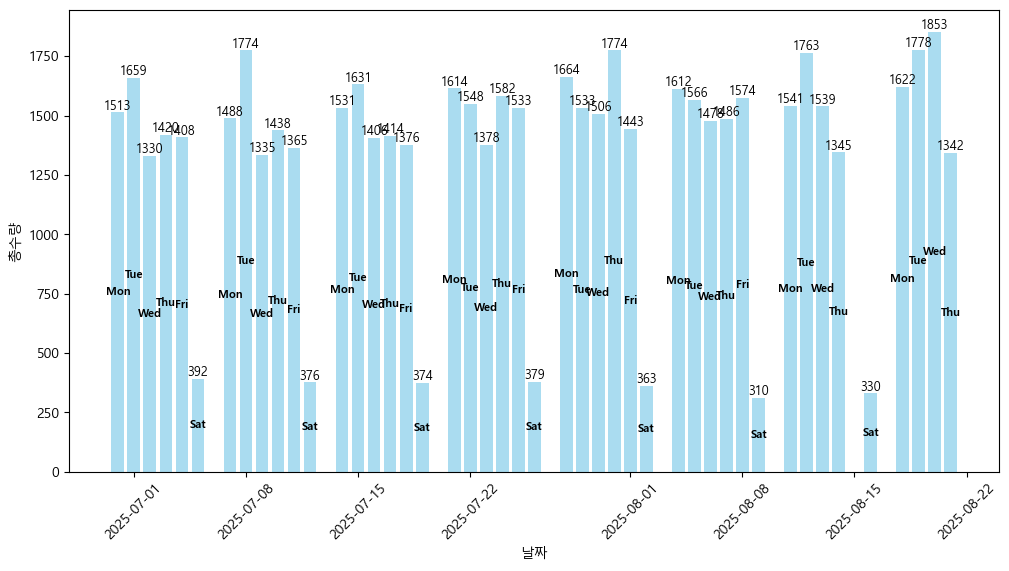

In [257]:
fig, ax1 = plt.subplots(figsize=(12,6))

bars = ax1.bar(df['delivery_date'], df['total_quantity'], alpha=0.7, color = 'skyblue', label="날짜별 수량")

for i, (bar, quantity, is_holiday, day) in enumerate(zip(bars, df['total_quantity'], df['is_holiday'], df['day'])):
    height = bar.get_height()
    
    # 막대 위에 수량 표시
    text = f'{int(height)}'
    if is_holiday:
        text += '\n(H)'  # 공휴일은 H로 표시
    
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             text,
             ha='center', va='bottom', fontsize=9)
    
    # 영어 요일을 줄임말로 변환
    day_short = day[:3]  # Monday -> Mon, Friday -> Fri
    
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             day_short,
             ha='center', va='center', fontsize=8, 
             color='black', weight='bold')

ax1.set_xlabel('날짜')
ax1.set_ylabel('총수량')
ax1.tick_params(axis='x', rotation=45)

In [258]:
# 요일 순서 고정정
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_avg = df.groupby('day').agg({
    'total_quantity': 'mean',
    'total_amount': 'mean',
}).round(2)

daily_avg.columns = ['평균_수량', '평균_금액']
daily_avg = daily_avg.reindex(weekday_order)

print("요일별 평균")
print(daily_avg)

요일별 평균
             평균_수량        평균_금액
day                            
Monday     1573.12  13236262.50
Tuesday    1656.50  13979025.00
Wednesday  1478.12  12053612.50
Thursday   1475.12  12010525.00
Friday     1449.83  12200133.33
Saturday    360.57   3173028.57
Sunday         NaN          NaN


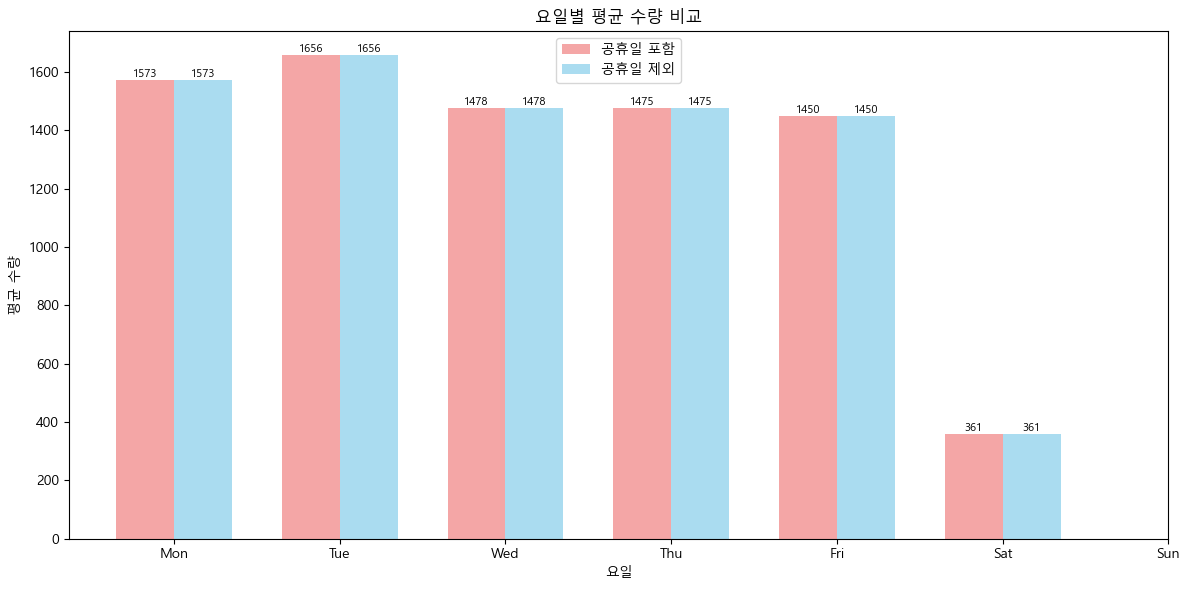

In [259]:
# 현재 공휴일에는 delivery_date가 없어서 공휴일 포함과 제외가 동일하게 공휴일을 담고 있지 않음

# 전체 데이터 평균
all_days_avg = df.groupby('day')['total_quantity'].mean().reindex(weekday_order)

# 공휴일 제외 평균
business_days_avg = df[df['is_holiday'] == False].groupby('day')['total_quantity'].mean().reindex(weekday_order)

# 차트 그리기
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(weekday_order))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], all_days_avg, width, 
               label='공휴일 포함', alpha=0.7, color='lightcoral')
bars2 = ax.bar([i + width/2 for i in x], business_days_avg, width,
               label='공휴일 제외', alpha=0.7, color='skyblue')

ax.set_xlabel('요일')
ax.set_ylabel('평균 수량')
ax.set_title('요일별 평균 수량 비교')
ax.set_xticks(x)
ax.set_xticklabels([day[:3] for day in weekday_order])
ax.legend()

# 막대 위에 수치 표시
for bar in bars1:
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    if not pd.isna(height):
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [260]:
df = get_total_quantity('2025-06-30', current_date)

df['date'] = pd.to_datetime(df['delivery_date'])
df['day'] = df['date'].dt.day_name()

years = pd.to_datetime(df['delivery_date'], errors='coerce').dt.year.dropna().astype(int).unique()
kr_holidays = holidays.KR(years=years, observed=True)

df['is_holiday'] = df['date'].apply(lambda x: x in kr_holidays)

selected_products = ["가정식 도시락", "가정식 도시락 곱빼기", "가정식 도시락(석식)", "프레시밀"]
df = df[df['product_name'].isin(selected_products)]

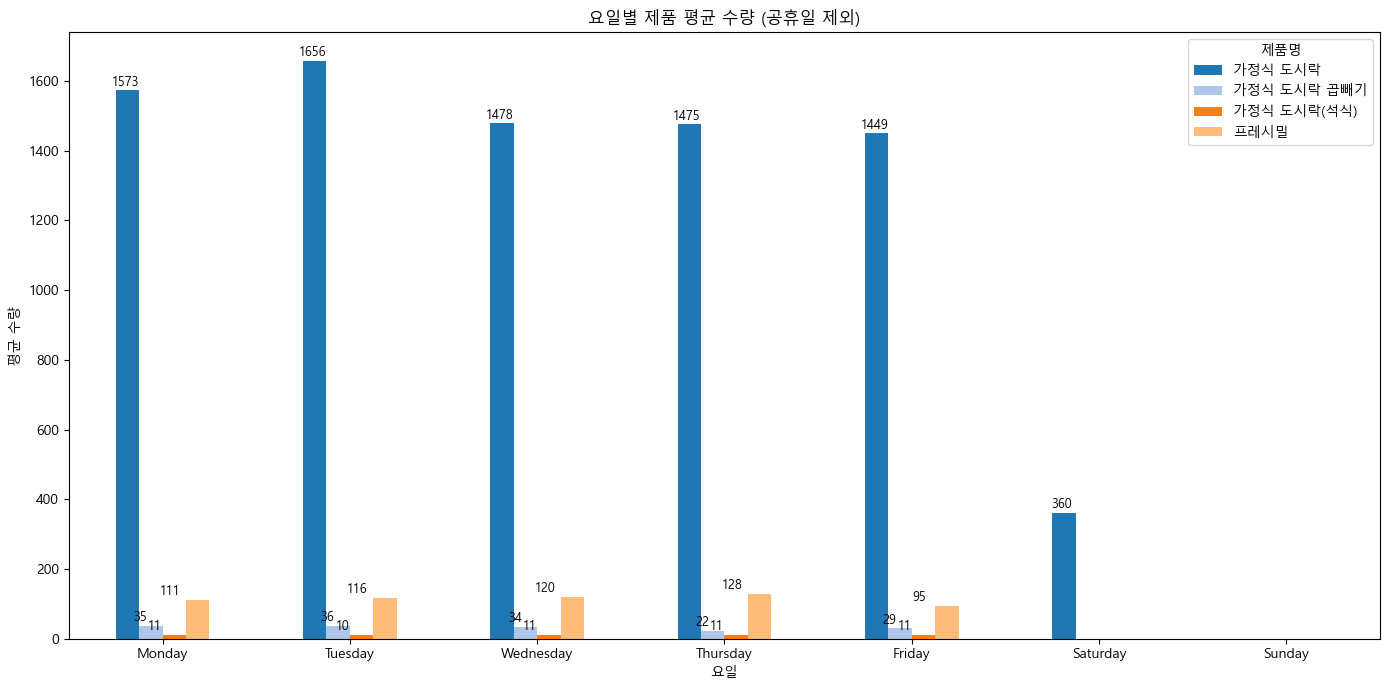

In [261]:
# 요일별 평균 수량 계산
df_weekday_avg = (
    df.groupby(['product_name', 'day'])['total_quantity']
    .mean()
    .reset_index()
)

# 3. pivot: 행=요일, 열=제품명
df_pivot = df_weekday_avg.pivot(index='day', columns='product_name', values='total_quantity')

# 4. 요일 순서 정렬
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_pivot = df_pivot.reindex(weekday_order)

# 5. 시각화
fig, ax = plt.subplots(figsize=(14,7))
colors = plt.cm.tab20.colors  # 여러 제품 색상 자동 할당
df_pivot.plot(kind='bar', ax=ax, color=colors)

ax.set_ylabel("평균 수량")
ax.set_xlabel("요일")
ax.set_title("요일별 제품 평균 수량 (공휴일 제외)")
plt.xticks(rotation=0)

# 6. 막대 위에 수량 표시
for i, weekday in enumerate(df_pivot.index):
    for j, product in enumerate(df_pivot.columns):
        value = df_pivot.loc[weekday, product]
        if not pd.isna(value):
            ax.text(i + j*0.08 - 0.2, value + 5,  # x 위치 조정, y는 막대 위 +5
                    f"{int(value)}",
                    ha='center', va='bottom', fontsize=9)

plt.legend(title="제품명")
plt.tight_layout()
plt.show()

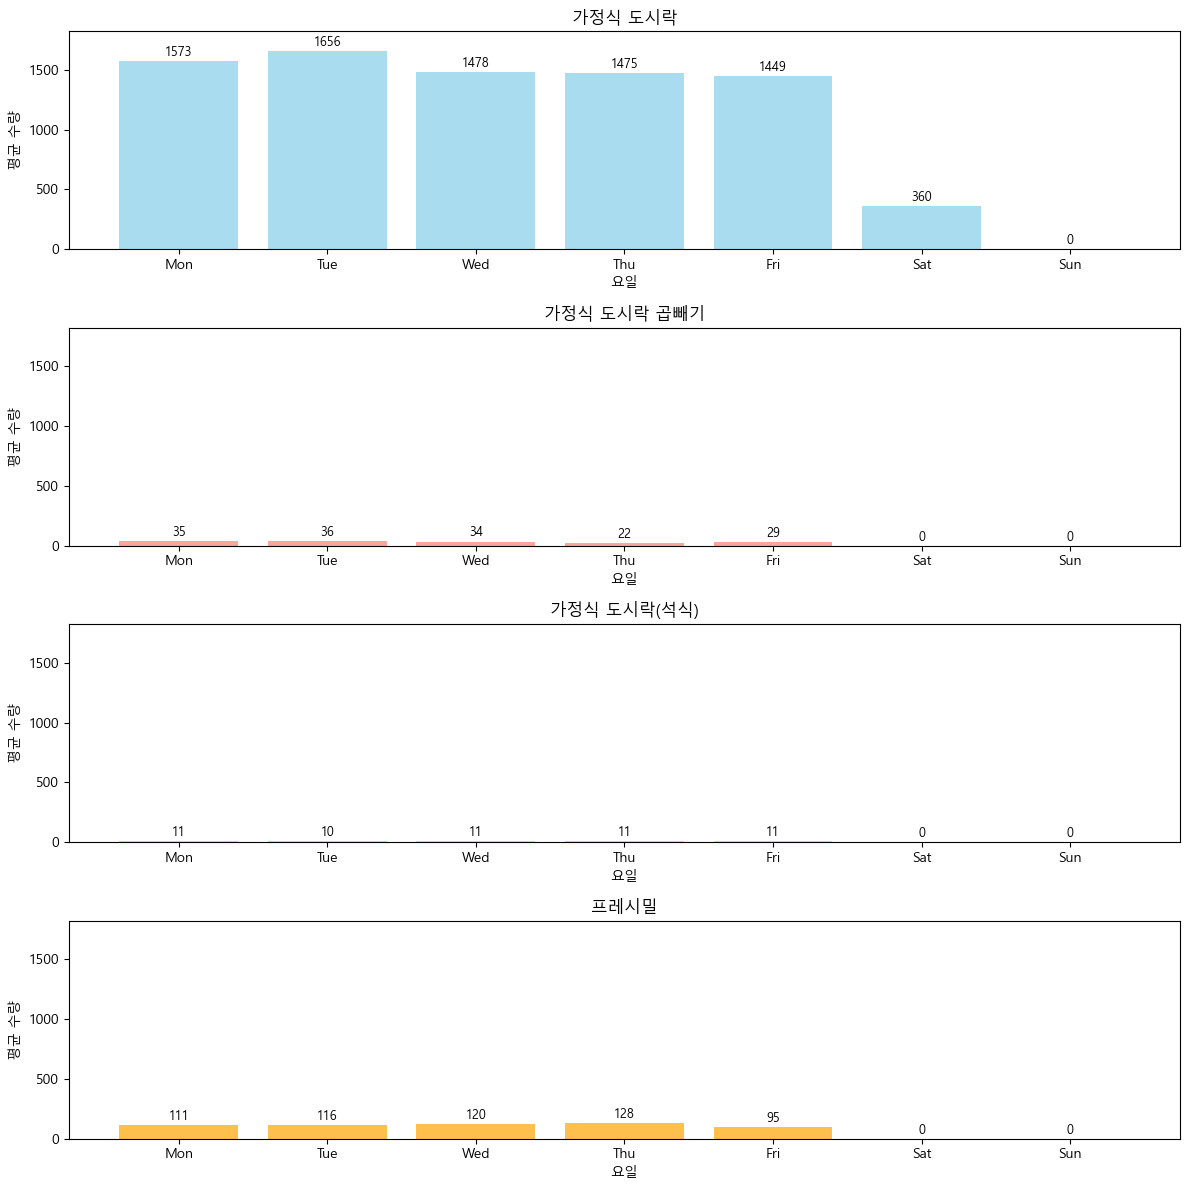

In [ ]:
# subplot 생성
n_plots = len(selected_products)
fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots*3))
if n_plots == 1:
    axes = [axes]

# 색상 지정
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink']

# y축 최대값 계산 (모든 subplot 동일 y축)
ymax = df_pivot[selected_products].max().max() * 1.1

# 요일명을 3자리로 변환하는 함수
def format_weekday(day_name):
    day_mapping = {
        'Monday': 'Mon',
        'Tuesday': 'Tue', 
        'Wednesday': 'Wed',
        'Thursday': 'Thu',
        'Friday': 'Fri',
        'Saturday': 'Sat',
        'Sunday': 'Sun'
    }
    return day_mapping.get(day_name, str(day_name)[:3])

# 요일 라벨 생성 (df_pivot.index의 실제 값 사용)
weekday_labels = [format_weekday(str(day)) for day in df_pivot.index]

for i, product in enumerate(selected_products):
    ax = axes[i]
    values = df_pivot[product].fillna(0)  # NaN은 0으로 처리
    bars = ax.bar(df_pivot.index, values, color=colors[i % len(colors)], alpha=0.7)

    ax.set_ylabel("평균 수량")
    ax.set_title(product)
    
    # 각 제품별 최대값 기준으로 y축 설정
    ymax = values.max() * 1.2
    ax.set_ylim(0, ymax)  # y축 동일
    
    # x축 라벨을 3자리 요일명으로 설정
    ax.set_xticks(df_pivot.index)
    ax.set_xticklabels(weekday_labels, rotation=0)
    ax.set_xlabel("요일")

    # 막대 위에 수치 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + ymax*0.01,  # 약간 위로 올림
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

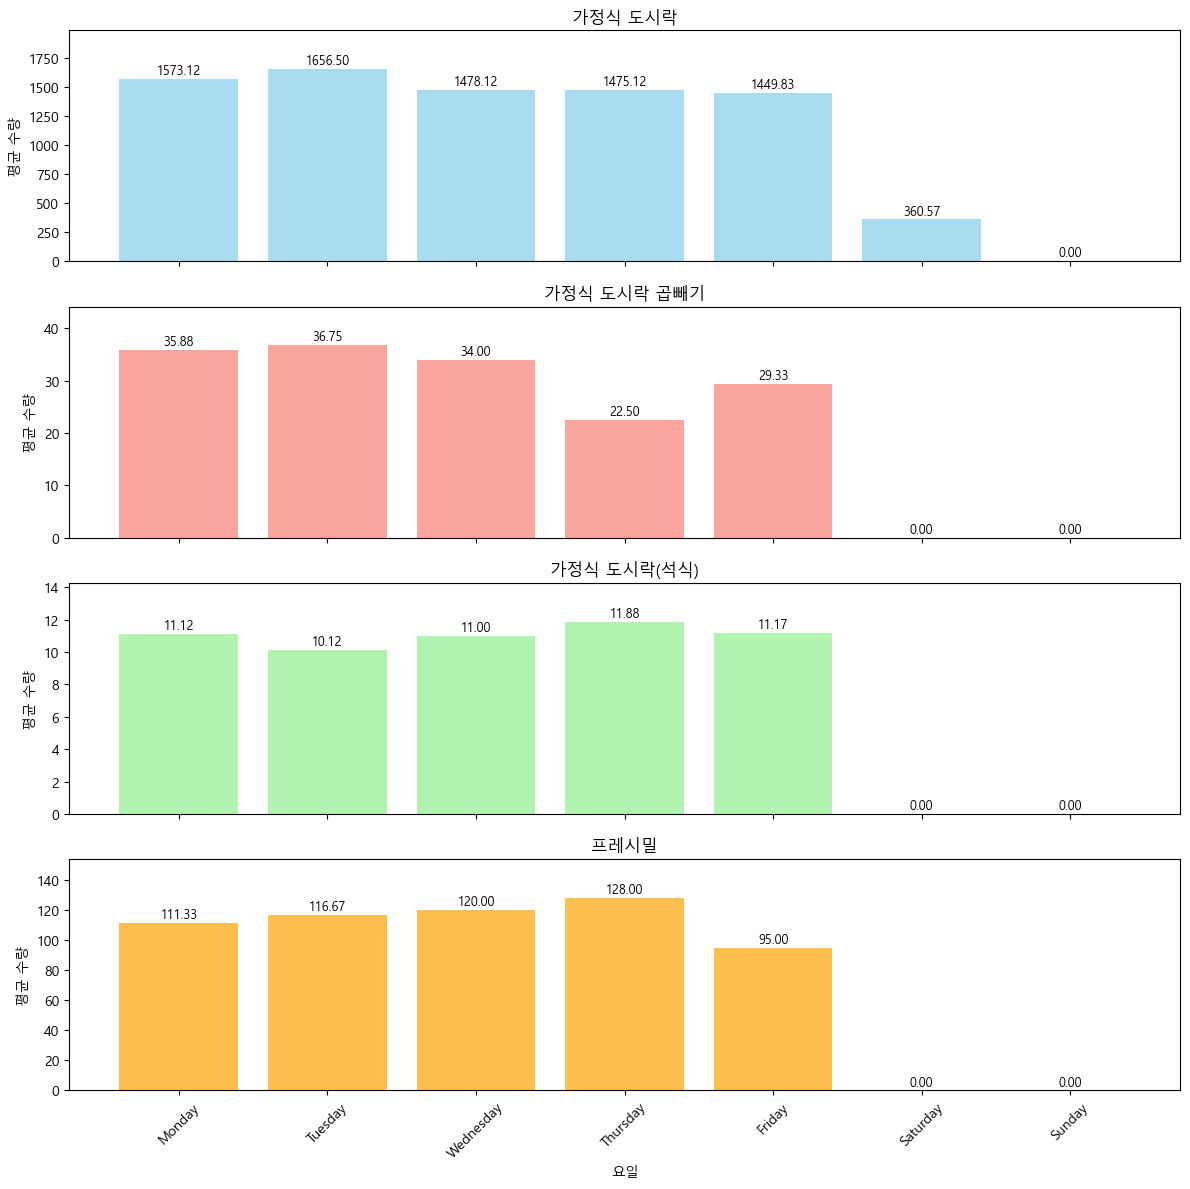

In [275]:
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple', 'pink']

# subplot 생성
fig, axes = plt.subplots(n_plots, 1, figsize=(12, n_plots*3), sharex=True)

for i, product in enumerate(selected_products):
    ax = axes[i]
    values = df_pivot[product].fillna(0)  # NaN은 0으로 처리
    bars = ax.bar(df_pivot.index, values, color=colors[i % len(colors)], alpha=0.7)

    ax.set_ylabel("평균 수량")
    ax.set_title(product)
    
    # 제품별 자동 y축 스케일링
    ax.set_ylim(0, values.max()*1.2)

    # 막대 위에 소숫점 둘째 자리까지 수치 표시
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + values.max()*0.01,  # 약간 위로 올림
            f"{height:.2f}",  # 소숫점 둘째 자리까지 표시
            ha='center',
            va='bottom',
            fontsize=9
        )

axes[-1].set_xlabel("요일")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()